In [43]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import DBLP
from torch_geometric.transforms import NormalizeFeatures
import random
from collections import defaultdict
import copy
import ast
import csv
import numpy as np

dataset = DBLP(root='../data/DBLP', transform=NormalizeFeatures())
hetero_data = dataset[0]

In [44]:
def convert_to_author_graph(hetero_data):    
    # Initialize adjacency list to count co-authorship
    adj_dict = defaultdict(int)
    
    # Process 'writes' and 'written_by' edges to count co-authorships
    author_to_paper = hetero_data['author', 'to', 'paper'].edge_index
    paper_to_author = hetero_data['paper', 'to', 'author'].edge_index
    
    for author, paper in author_to_paper.t().tolist():
        coauthors = paper_to_author[1, paper_to_author[0] == paper].tolist()
        for coauthor in coauthors:
            if author != coauthor:
                edge = tuple([author, coauthor])
                adj_dict[edge] += 1
    
    # Create edge_index and edge_weight tensors
    edge_index = torch.tensor(list(adj_dict.keys()), dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(list(adj_dict.values()), dtype=torch.float)
    
    # Create the homogeneous graph
    data = Data()
    data.x = hetero_data['author'].x
    data.edge_index = edge_index
    data.edge_weight = edge_weight

    data.train_mask = hetero_data['author'].train_mask
    data.val_mask = hetero_data['author'].val_mask
    data.test_mask = hetero_data['author'].test_mask
    data.y = hetero_data['author'].y
    
    return data

# Convert the dataset
data = convert_to_author_graph(hetero_data)

In [45]:
GCN_GNNExplainer_explanations = {}
GCN_IG_explanations = {}
GAT_GNNExplainer_explanations = {}
GAT_IG_explanations = {}

with open("../results/Explanations_GCN_GNNExplainer_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GCN_GNNExplainer_explanations[index] = (node_indices_list, node_weights_list)

with open("../results/Explanations_GCN_IntegratedGradients_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GCN_IG_explanations[index] = (node_indices_list, node_weights_list)

with open("../results/Explanations_GAT_GNNExplainer_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GAT_GNNExplainer_explanations[index] = (node_indices_list, node_weights_list)

with open("../results/Explanations_GAT_IntegratedGradients_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GAT_IG_explanations[index] = (node_indices_list, node_weights_list)

In [46]:
def get_node_frequencies(explanations, significant_node_masks):
    node_frequencies_big = defaultdict(int)
    node_frequencies_small = defaultdict(int)

    for i, (node_indices, node_weights) in explanations.items():
        node_indices = torch.tensor(node_indices)
        node_weights = torch.tensor(node_weights)

        significant_node_mask_big = node_weights > significant_node_masks[0]
        significant_node_mask_small = node_weights > significant_node_masks[1]
        significant_nodes_big = node_indices[significant_node_mask_big]
        significant_nodes_small = node_indices[significant_node_mask_small]

        significant_nodes_big = np.unique(significant_nodes_big.numpy())
        significant_nodes_small = np.unique(significant_nodes_small.numpy())

        for node in significant_nodes_big:
            node_frequencies_big[node] += 1

        for node in significant_nodes_small:
            node_frequencies_small[node] += 1

    return node_frequencies_big, node_frequencies_small


GCN_GNNExplainer_node_freq_big, GCN_GNNExplainer_node_freq_small = get_node_frequencies(GCN_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GCN_IG_node_freq_big, GCN_IG_node_freq_small = get_node_frequencies(GCN_IG_explanations, significant_node_masks=(0.003, 0.0001))
GAT_GNNExplainer_node_freq_big, GAT_GNNExplainer_node_freq_small = get_node_frequencies(GAT_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GAT_IG_node_freq_big, GAT_IG_node_freq_small = get_node_frequencies(GAT_IG_explanations, significant_node_masks=(0.003, 0.0001))

In [47]:
def divide_into_chunks(freq, n):
    lst = sorted(freq.items(), key=lambda x: x[1])
    """Divide the list lst into n equally-sized chunks."""
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


num_bins = 10
GCN_GNNExplainer_bins_big = divide_into_chunks(GCN_GNNExplainer_node_freq_big, num_bins)
GCN_GNNExplainer_bins_small = divide_into_chunks(GCN_GNNExplainer_node_freq_small, num_bins)
GCN_IG_bins_big = divide_into_chunks(GCN_IG_node_freq_big, num_bins)
GCN_IG_bins_small = divide_into_chunks(GCN_IG_node_freq_small, num_bins)
GAT_GNNExplainer_bins_big = divide_into_chunks(GAT_GNNExplainer_node_freq_big, num_bins)
GAT_GNNExplainer_bins_small = divide_into_chunks(GAT_GNNExplainer_node_freq_small, num_bins)
GAT_IG_bins_big = divide_into_chunks(GAT_IG_node_freq_big, num_bins)
GAT_IG_bins_small = divide_into_chunks(GAT_IG_node_freq_small, num_bins)

In [48]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features['author'], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.y.max().item() + 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x

GCN_model = GCN(hidden_channels=16)

In [49]:
GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def GCN_train():
    GCN_model.train()
    GCN_optimizer.zero_grad()  # Clear gradients.
    out = GCN_model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    GCN_optimizer.step()  # Update parameters based on gradients.
    return loss

def GCN_test(mask):
    GCN_model.eval()
    out = GCN_model(data.x, data.edge_index, data.edge_weight)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [50]:
for epoch in range(1, 101):
    loss = GCN_train()
    val_acc = GCN_test(data.val_mask)
    test_acc = GCN_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.3845, Val: 0.3500, Test: 0.3985
Epoch: 002, Loss: 1.3738, Val: 0.4125, Test: 0.4513
Epoch: 003, Loss: 1.3638, Val: 0.4250, Test: 0.4762
Epoch: 004, Loss: 1.3560, Val: 0.4225, Test: 0.4756
Epoch: 005, Loss: 1.3382, Val: 0.4175, Test: 0.4777
Epoch: 006, Loss: 1.3278, Val: 0.4225, Test: 0.4790
Epoch: 007, Loss: 1.3174, Val: 0.4225, Test: 0.4876
Epoch: 008, Loss: 1.3024, Val: 0.4250, Test: 0.4980
Epoch: 009, Loss: 1.2891, Val: 0.4325, Test: 0.5124
Epoch: 010, Loss: 1.2801, Val: 0.4425, Test: 0.5269
Epoch: 011, Loss: 1.2614, Val: 0.4575, Test: 0.5422
Epoch: 012, Loss: 1.2554, Val: 0.4800, Test: 0.5662
Epoch: 013, Loss: 1.2352, Val: 0.4975, Test: 0.5895
Epoch: 014, Loss: 1.2166, Val: 0.5250, Test: 0.6107
Epoch: 015, Loss: 1.2056, Val: 0.5500, Test: 0.6291
Epoch: 016, Loss: 1.1879, Val: 0.5675, Test: 0.6463
Epoch: 017, Loss: 1.1750, Val: 0.5725, Test: 0.6570
Epoch: 018, Loss: 1.1602, Val: 0.5875, Test: 0.6641
Epoch: 019, Loss: 1.1614, Val: 0.6000, Test: 0.6684
Epoch: 020, 

In [51]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features['author'], hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, data.y.max().item() + 1)

    def forward(self, x, edge_index, edge_weight):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr=edge_weight)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr=edge_weight)
        return x

GAT_model = GAT(hidden_channels=8, heads=8)
print(GAT_model)

GAT(
  (conv1): GATConv(334, 8, heads=8)
  (conv2): GATConv(64, 4, heads=1)
)


In [52]:
GAT_optimizer = torch.optim.Adam(GAT_model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def GAT_train():
    GAT_model.train()
    GAT_optimizer.zero_grad()
    out = GAT_model(data.x, data.edge_index, data.edge_weight)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    GAT_optimizer.step()
    return loss

def GAT_test(mask):
    GAT_model.eval()
    out = GAT_model(data.x, data.edge_index, data.edge_weight)
    out = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [53]:
for epoch in range(1, 81):
    loss = GAT_train()
    val_acc = GAT_test(data.val_mask)
    test_acc = GAT_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.3887, Val: 0.3850, Test: 0.4173
Epoch: 002, Loss: 1.3673, Val: 0.4200, Test: 0.4673
Epoch: 003, Loss: 1.3503, Val: 0.4400, Test: 0.4906
Epoch: 004, Loss: 1.3355, Val: 0.4475, Test: 0.5020
Epoch: 005, Loss: 1.3290, Val: 0.4500, Test: 0.5088
Epoch: 006, Loss: 1.3132, Val: 0.4500, Test: 0.5146
Epoch: 007, Loss: 1.3004, Val: 0.4475, Test: 0.5192
Epoch: 008, Loss: 1.2886, Val: 0.4625, Test: 0.5269
Epoch: 009, Loss: 1.2724, Val: 0.4675, Test: 0.5352
Epoch: 010, Loss: 1.2699, Val: 0.4700, Test: 0.5413
Epoch: 011, Loss: 1.2543, Val: 0.4825, Test: 0.5514
Epoch: 012, Loss: 1.2375, Val: 0.5025, Test: 0.5609
Epoch: 013, Loss: 1.2329, Val: 0.5050, Test: 0.5729
Epoch: 014, Loss: 1.2131, Val: 0.5150, Test: 0.5809
Epoch: 015, Loss: 1.1991, Val: 0.5225, Test: 0.5956
Epoch: 016, Loss: 1.1981, Val: 0.5275, Test: 0.6131
Epoch: 017, Loss: 1.1826, Val: 0.5375, Test: 0.6202
Epoch: 018, Loss: 1.1563, Val: 0.5475, Test: 0.6349
Epoch: 019, Loss: 1.1492, Val: 0.5625, Test: 0.6506
Epoch: 020, 

In [54]:
import torch_geometric.utils as pyg_utils


def generate_perturbations(data, nodes_to_remove):
    data = copy.deepcopy(data)
    nodes_to_remove = set(nodes_to_remove)

    mask = torch.ones(data.x.size(0), dtype=torch.bool)
    mask[list(nodes_to_remove)] = False
    
    data.x = data.x[mask]

    all_nodes = set(range(4057))
    nodes_to_retain = all_nodes.difference(nodes_to_remove)
    data.edge_index, _, edge_mask = pyg_utils.subgraph(sorted(nodes_to_retain), data.edge_index, relabel_nodes=True, return_edge_mask=True)
    data.edge_weight = data.edge_weight[edge_mask]

    return data, mask


def calc_rrmse(y, y_hat):
    residuals = y - y_hat
    squared_norm_residuals = torch.linalg.vector_norm(residuals)**2
    squared_norm_orig = torch.linalg.vector_norm(y_hat)**2
    return torch.sqrt(squared_norm_residuals / squared_norm_orig)


def get_logit_diff(data, perturbed_data, model, mask):
    model.eval()
    with torch.no_grad():
        out_orig = model(data.x, data.edge_index, data.edge_weight)
        out_perturb = model(perturbed_data.x, perturbed_data.edge_index, perturbed_data.edge_weight)
    return calc_rrmse(out_orig[mask], out_perturb)

In [55]:
num_samples = 10

GCN_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GCN_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GCN_IG_results_small = torch.zeros(num_bins, num_samples)
GCN_IG_results_big = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GAT_IG_results_small = torch.zeros(num_bins, num_samples)
GAT_IG_results_big = torch.zeros(num_bins, num_samples)

GCN_GNNExplainer_avg_freq_small = []
GCN_GNNExplainer_avg_freq_big = []
GCN_IG_avg_freq_small = []
GCN_IG_avg_freq_big = []
GAT_GNNExplainer_avg_freq_small = []
GAT_GNNExplainer_avg_freq_big = []
GAT_IG_avg_freq_small = []
GAT_IG_avg_freq_big = []


def populate_result_tensors(bins, model, avg_freq, res, perturb_size):
    for i, bin in enumerate(bins):
        avg_freq.append(np.mean([i[1] for i in bin]))
        for j in range(num_samples):
            nodes = [i[0] for i in bin]
            sampled_nodes = random.sample(nodes, perturb_size)
            perturbed_data, mask = generate_perturbations(data, sampled_nodes)
            res[i, j] = get_logit_diff(data, perturbed_data, model, mask)


perturb_size_small = len(GCN_GNNExplainer_bins_small[0]) // 2
perturb_size_big = len(GCN_GNNExplainer_bins_big[0]) // 2

populate_result_tensors(GCN_GNNExplainer_bins_small, GCN_model, GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small, perturb_size_small)
populate_result_tensors(GCN_GNNExplainer_bins_big, GCN_model, GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big, perturb_size_big)
populate_result_tensors(GCN_IG_bins_small, GCN_model, GCN_IG_avg_freq_small, GCN_IG_results_small, perturb_size_small)
populate_result_tensors(GCN_IG_bins_big, GCN_model, GCN_IG_avg_freq_big, GCN_IG_results_big, perturb_size_big)
populate_result_tensors(GAT_GNNExplainer_bins_small, GAT_model, GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small, perturb_size_small)
populate_result_tensors(GAT_GNNExplainer_bins_big, GAT_model, GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big, perturb_size_big)
populate_result_tensors(GAT_IG_bins_small, GAT_model, GAT_IG_avg_freq_small, GAT_IG_results_small, perturb_size_small)
populate_result_tensors(GAT_IG_bins_big, GAT_model, GAT_IG_avg_freq_big, GAT_IG_results_big, perturb_size_big)

In [56]:
GCN_baseline_big = torch.zeros(num_samples)
GCN_baseline_small = torch.zeros(num_samples)
GAT_baseline_big = torch.zeros(num_samples)
GAT_baseline_small = torch.zeros(num_samples)


def populate_baseline_tensors(freq, bins, model, res):
    for i in range(num_samples):
        half_size = len(bins[0]) // 2
        nodes = [i[0] for i in freq.items()]
        sampled_nodes = random.sample(nodes, half_size)
        perturbed_data, mask = generate_perturbations(data, sampled_nodes)
        res[i] = get_logit_diff(data, perturbed_data, model, mask)


populate_baseline_tensors(GCN_GNNExplainer_node_freq_big, GCN_GNNExplainer_bins_big, GCN_model, GCN_baseline_big)
populate_baseline_tensors(GCN_GNNExplainer_node_freq_small, GCN_GNNExplainer_bins_small, GCN_model, GCN_baseline_small)
populate_baseline_tensors(GAT_GNNExplainer_node_freq_big, GAT_GNNExplainer_bins_big, GAT_model, GAT_baseline_big)
populate_baseline_tensors(GAT_GNNExplainer_node_freq_small, GAT_GNNExplainer_bins_small, GAT_model, GAT_baseline_small)

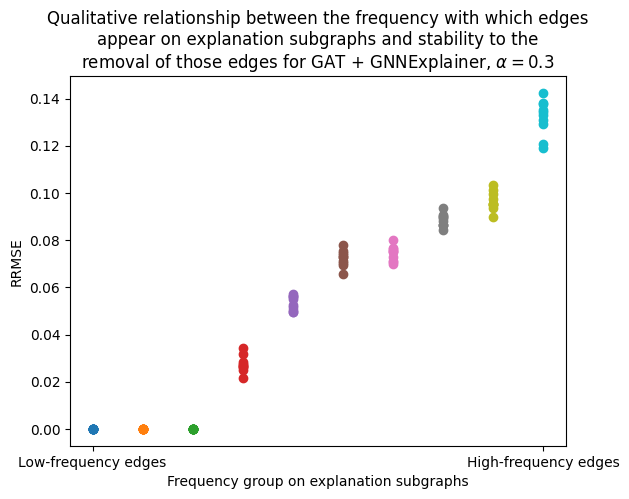

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(num_bins):
    x = [i] * num_samples
    y = GCN_GNNExplainer_results_small[i].detach().numpy()
    ax.scatter(x, y, label=f'Bin {i+1}')

ax.set_xlabel('Frequency group on explanation subgraphs')
ax.set_ylabel('RRMSE')
ax.set_xticks([0, num_bins-1])  # Set ticks only at the extremes
ax.set_xticklabels(['Low-frequency edges', 'High-frequency edges'])
ax.set_title('Qualitative relationship between the frequency with which edges\nappear on explanation subgraphs and stability to the\nremoval of those edges for GAT + GNNExplainer, $\\alpha=0.3$')
plt.show()

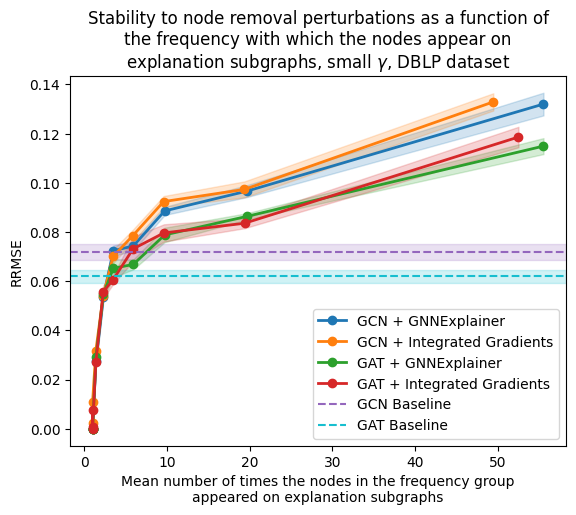

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_with_confidence_intervals(avg_freq, results, label, color):
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)


def plot_baseline(baseline, label, color):
    mean = np.mean(baseline)
    sem_baseline = sem(baseline)

    ci_lower = mean - 1.96 * sem_baseline
    ci_upper = mean + 1.96 * sem_baseline

    plt.axhline(y=mean, color=color, linestyle='--', label=label)
    plt.fill_between([0, 1], ci_lower, ci_upper, color=color, alpha=0.2, transform=plt.gca().get_yaxis_transform())


plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_small, GCN_IG_results_small.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_small, GAT_IG_results_small.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_small.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_small.numpy(), "GAT Baseline", colors[5])
# plot_with_confidence_intervals(tagcn_avg_freq_small, tagcn_results_small.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, small $\\gamma$, DBLP dataset')
plt.show()

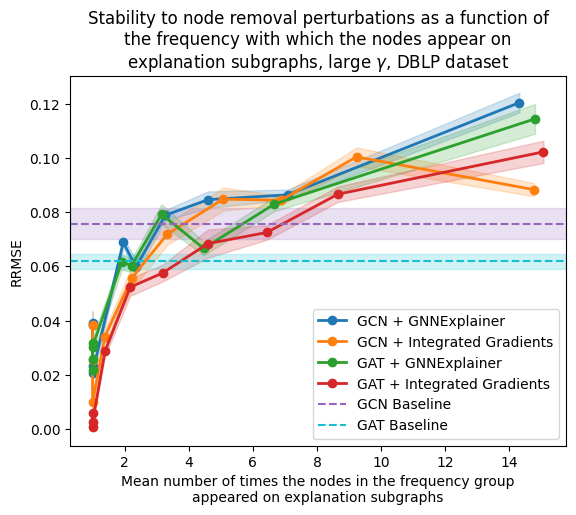

In [59]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_big, GCN_IG_results_big.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_big, GAT_IG_results_big.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_big.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_small.numpy(), "GAT Baseline", colors[5])
# plot_with_confidence_intervals(tagcn_avg_freq_small, tagcn_results_small.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, large $\\gamma$, DBLP dataset')
plt.show()

P-value for Node removal DBLP, GCN + GNNExplainer, small $\gamma$: 0.00945431955267444
P-value for Node removal DBLP, GCN + Integrated Gradients, small $\gamma$: 0.0070460335851570315
P-value for Node removal DBLP, GAT + GNNExplainer, small $\gamma$: 0.013490562038768958
P-value for Node remvoval DBLP, GAT + Integrated Gradients, small $\gamma$: 0.009444811597169415


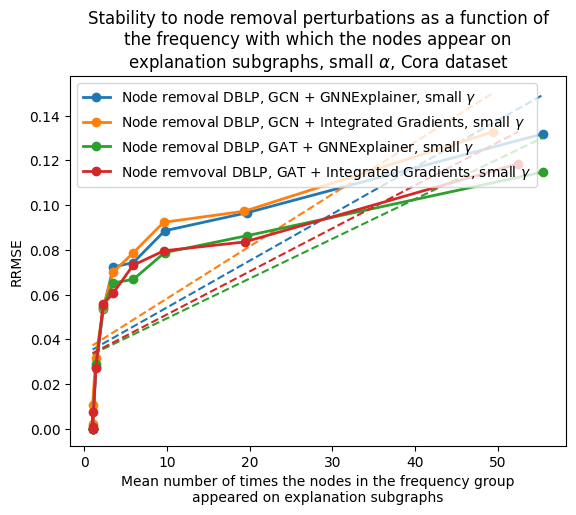

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, linregress

def best_fit(avg_freq, results, label, color):
    mean_values = np.mean(results, axis=1)

    slope, intercept, r_value, p_value_linear, std_err = linregress(avg_freq, mean_values)

    best_p_value = p_value_linear
    fit_line = slope * np.array(avg_freq) + intercept

    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')
    plt.plot(avg_freq, fit_line, linestyle='--', color=color)

    print(f"P-value for {label}: {best_p_value}")

plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

best_fit(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small.numpy(), 'Node removal DBLP, GCN + GNNExplainer, small $\\gamma$', colors[0])
best_fit(GCN_IG_avg_freq_small, GCN_IG_results_small.numpy(), 'Node removal DBLP, GCN + Integrated Gradients, small $\\gamma$', colors[1])
best_fit(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small.numpy(), 'Node removal DBLP, GAT + GNNExplainer, small $\\gamma$', colors[2])
best_fit(GAT_IG_avg_freq_small, GAT_IG_results_small.numpy(), 'Node remvoval DBLP, GAT + Integrated Gradients, small $\\gamma$', colors[3])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, small $\\alpha$, Cora dataset')
plt.show()

P-value for Node removal DBLP, GCN + GNNExplainer, large $\gamma$: 0.0010769780266646624
P-value for Node removal DBLP, GCN + Integrated Gradients, large $\gamma$: 0.006622981009455447
P-value for Node removal DBLP, GAT + GNNExplainer, large $\gamma$: 0.0010676180815459987
P-value for Node removal DBLP, GAT + Integrated Gradients, large $\gamma$: 0.0012457386754498765


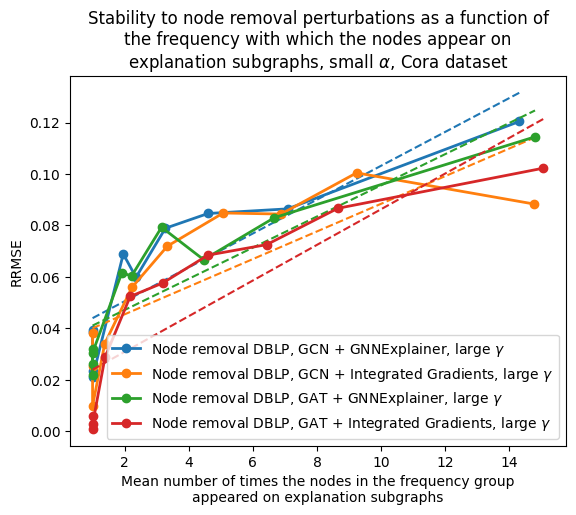

In [61]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

best_fit(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big.numpy(), 'Node removal DBLP, GCN + GNNExplainer, large $\\gamma$', colors[0])
best_fit(GCN_IG_avg_freq_big, GCN_IG_results_big.numpy(), 'Node removal DBLP, GCN + Integrated Gradients, large $\\gamma$', colors[1])
best_fit(GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big.numpy(), 'Node removal DBLP, GAT + GNNExplainer, large $\\gamma$', colors[2])
best_fit(GAT_IG_avg_freq_big, GAT_IG_results_big.numpy(), 'Node removal DBLP, GAT + Integrated Gradients, large $\\gamma$', colors[3])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, small $\\alpha$, Cora dataset')
plt.show()